# Training

In [14]:
#Import relevant packages
import sys
import time
import numpy as np
import pandas as pd
import seaborn as sns #for plotting multi-graphs
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import f1_score, classification_report

#models
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import silhouette_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

#All command lines can be output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#active google drive
''' Uncomment it if you use google drive
from google.colab import drive
drive.mount('/content/drive')
!nvidia-smi
'''

" Uncomment it if you use google drive\nfrom google.colab import drive\ndrive.mount('/content/drive')\n!nvidia-smi\n"

## Data processing

In [2]:
#Read training data
source_path = "5. Binary Classification with a Bank Churn Dataset/train.csv"
df = pd.read_csv(source_path)

#Mapping gender and geography to numeric values
df_process = df
df_process['Gender'].replace({'Male': 0, 'Female': 1},inplace=True)
df_process['Geography'].replace({'France': 0, 'Germany': 1,'Spain':2},inplace=True)

#Check class record distribution in each classes, and remove customerId and Surname columns
class_data = df_process.drop(columns=['CustomerId', 'Surname']).groupby("Exited")

In [3]:
#Asssume normal distribution range of 99.73% is in [mean - 3 * std, mean + 3 * std] to remove outliers
def normal_distribution_outlier_remove(group_data):
    #record the orginal number of group records
    records_count = group_data.shape[0]
    
    for col in group_data.columns[1:-1]: #skip the id and last Exited column
        #store the mean and std of each column
        mean = group_data[col].mean()
        std = group_data[col].std()
        #Update the column values which locate in 99.73% that follows normal distribution
        group_data.loc[:,col] = group_data[col].where(((group_data[col])>=(mean - 3*std))
                  & ((group_data[col])<=(mean + 3*std)))

    #record the numbers of outliers
    records_count = records_count - group_data.dropna().shape[0]
    #print the number of outliers dropped
    print(str(records_count)+" outliers of class "+str(group_data["Exited"].iloc[0])+" removed.")
    
    return group_data.dropna()

In [4]:
#Separtate the data by classes
class_data_0 = class_data.get_group(0)
class_data_1 = class_data.get_group(1)

#Remove outliers of each classes
class_data_0_outlier_remove = normal_distribution_outlier_remove(class_data_0.copy())
class_data_1_outlier_remove = normal_distribution_outlier_remove(class_data_1.copy())

#Concat the class data
df_process = pd.concat([class_data_0_outlier_remove,class_data_1_outlier_remove]).sort_values(['id'])

2604 outliers of class 0 removed.
541 outliers of class 1 removed.


In [5]:
#standardization
z_scaler = preprocessing.StandardScaler()
df_z = z_scaler.fit_transform(df_process.drop(columns=['id','Exited']))
df_z = pd.DataFrame(df_z)

#normalization
minmax_scaler = preprocessing.MinMaxScaler().fit(df_z)
df_norm = minmax_scaler.transform(df_z)

#Convert to dataframe
df_processed = pd.DataFrame(df_norm)
column_labels = ["CreditScore","Geography","Gender","Age","Tenure","Balance",
                "NumOfProducts","HasCrCard","IsActiveMember","EstimatedSalary"]
df_processed.columns = column_labels
df_processed.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,0.585421,0.0,0.0,0.288462,0.3,0.00000,0.5,1.0,0.0,0.907279
1,0.492027,0.0,0.0,0.288462,0.1,0.00000,0.5,1.0,1.0,0.247483
2,0.608200,0.0,0.0,0.423077,1.0,0.00000,0.5,1.0,0.0,0.924364
3,0.387244,0.0,0.0,0.307692,0.2,0.62454,0.0,1.0,1.0,0.422787
4,0.694761,1.0,0.0,0.288462,0.5,0.00000,0.5,1.0,1.0,0.075293


## Model training and evaluation

In [6]:
#Split into training and validation set
#Stratified k-Fold Cross Validation
#Not balance Postive and Negative samples, use this to ensure the ratio
#Remove attributes with less importance towards attribute Exited
X=df_processed.drop(columns=['Tenure','HasCrCard','EstimatedSalary']).values
y=df_process['Exited'].values
#Select K=10
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

### Trained on CPU i9-14900K at 5.3GHz, Memory 64GB 3600MHz.

In [15]:
#Train and Evaluate template
def train_and_evaluate(model_name):
    model_Best = None
    macro_f1_Best = 0.0
    micro_f1_Best = 0.0
    training_time_total = 0.0
    StratiedKFold = 0
    num_folds = 0
    y_test_Best = []
    y_pred_Best = []
    
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        print(f'StratifiedKFold {i+1}:')
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # Training Time start
        train_start = time.time()
        
        # fit the data into model
        if model_name == "LogisticRegression":
            model = LogisticRegression().fit(X_train, y_train)
        elif model_name == "SupportVectorClassification":
            model = SVC().fit(X_train, y_train)
        elif model_name == "KMeans":
            model = KMeans(n_clusters=2, random_state=42, n_init='auto').fit(X_train)
        elif model_name == "DNN":
            model = MLPClassifier(hidden_layer_sizes=(16, ), activation='relu', solver='adam', random_state=42).fit(X_train, y_train)
        elif model_name == "RandomForestClassifier":
            model = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train)
        elif model_name == "DecisionTreeClassifier":
            model = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
        elif model_name == "XGBoost":
            model = xgb.XGBClassifier().fit(X_train, y_train)
        
        # Training Time stop
        train_stop = time.time()
        training_time = train_stop-train_start
        print(f"Training time: {training_time} s")
        
        # put test data to predict
        y_pred = model.predict(X_test)
        
        # validation 
        micro_f1 = f1_score(y_test,y_pred,average='micro')
        macro_f1 = f1_score(y_test,y_pred,average='macro')
        print('micro f1: ', micro_f1)
        print('marco f1: ', macro_f1)
      
        # Update best model with evaluation results
        if macro_f1 > macro_f1_Best:
            macro_f1_Best = macro_f1
            micro_f1_Best = micro_f1
            model_Best = model
            y_test_Best = y_test
            y_pred_Best = y_pred
            StratiedKFold = i+1
        
        # Sum total training time
        training_time_total += training_time
        num_folds += 1

        print('\n')

    
    print('Best model occurs at Stratied K Fold = ', StratiedKFold)
    
    # model size
    model_size = sys.getsizeof(model_Best)
    print(f"model size: {model_size} bytes")
        
    # Calculate average training time
    training_time_average = training_time_total / num_folds
    print(f"Average training time: {training_time_average} s \n")


    # Show Best F1 scores
    print('Best micro f1: ', micro_f1_Best)
    print('Best marco f1: ', macro_f1_Best,'\n')

    # Check class precision and recall 
    print("Classfication report on Exited = 0, 1")
    report = classification_report(y_test_Best, y_pred_Best)
    print(report)
 
    
    #Plot ROC curve
    display = RocCurveDisplay.from_predictions(
        y_test_Best,
        y_pred_Best,
        name=f"{model_name}",
        color="darkorange",
        plot_chance_level=True,
    )
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Receiver Operating Characteristic (ROC) Curve of Model: {model_name}",
    )
    
    return model_Best


StratifiedKFold 1:
Training time: 0.0866081714630127 s
micro f1:  0.8396442028537896
marco f1:  0.7136322480062361


StratifiedKFold 2:
Training time: 0.08156442642211914 s
micro f1:  0.8408796096114646
marco f1:  0.7145835985401918


StratifiedKFold 3:
Training time: 0.0791475772857666 s
micro f1:  0.8388411884613008
marco f1:  0.709942805434416


StratifiedKFold 4:
Training time: 0.07400059700012207 s
micro f1:  0.8363703749459509
marco f1:  0.7062787899658947


StratifiedKFold 5:
Training time: 0.07699942588806152 s
micro f1:  0.8370498486626722
marco f1:  0.7095090553634756


StratifiedKFold 6:
Training time: 0.0775899887084961 s
micro f1:  0.8406325282599296
marco f1:  0.7163096896146559


StratifiedKFold 7:
Training time: 0.08253884315490723 s
micro f1:  0.8382852554203472
marco f1:  0.7117955205947996


StratifiedKFold 8:
Training time: 0.08467435836791992 s
micro f1:  0.8354438198776948
marco f1:  0.7037842376756236


StratifiedKFold 9:
Training time: 0.07714080810546875 s
micr

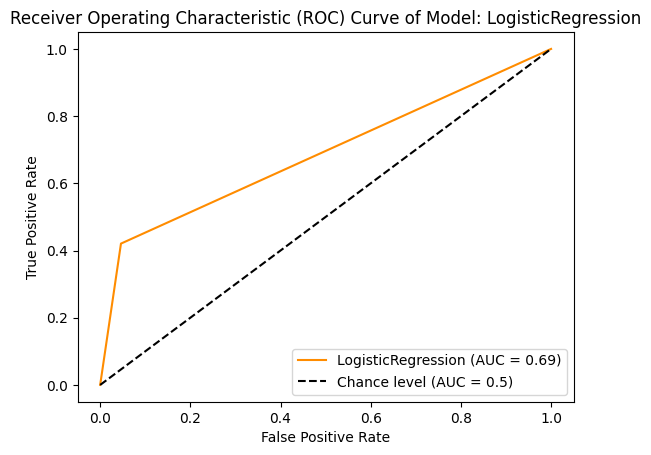

In [11]:
#Logistic Regression
model_LogisticRegression = train_and_evaluate("LogisticRegression")

StratifiedKFold 1:
Training time: 157.86749505996704 s
micro f1:  0.8662054481438013
marco f1:  0.7641594048849858


StratifiedKFold 2:
Training time: 168.04041361808777 s
micro f1:  0.8607696584100315
marco f1:  0.753089286255608


StratifiedKFold 3:
Training time: 155.4063606262207 s
micro f1:  0.8615109024646365
marco f1:  0.7542615642109093


StratifiedKFold 4:
Training time: 144.35277915000916 s
micro f1:  0.8633640126011489
marco f1:  0.7581796049133598


StratifiedKFold 5:
Training time: 201.4751546382904 s
micro f1:  0.8607696584100315
marco f1:  0.7541548696057585


StratifiedKFold 6:
Training time: 154.44390082359314 s
micro f1:  0.8637964049663353
marco f1:  0.7608367849842618


StratifiedKFold 7:
Training time: 205.31433629989624 s
micro f1:  0.860399036382729
marco f1:  0.7522886418896766


StratifiedKFold 8:
Training time: 155.2531714439392 s
micro f1:  0.858916548273519
marco f1:  0.7487839531218705


StratifiedKFold 9:
Training time: 191.64093351364136 s
micro f1:  0.85

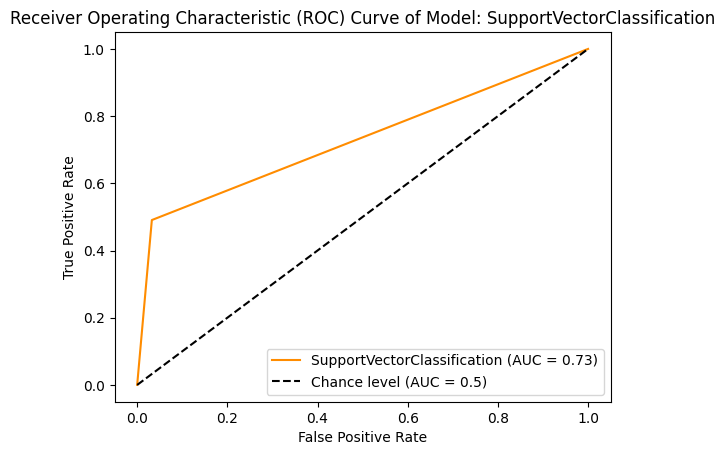

In [19]:
#SVM Classifier
model_svmClassfier = train_and_evaluate("SupportVectorClassification")

StratifiedKFold 1:
Training time: 0.02899909019470215 s
micro f1:  0.584656248069677
marco f1:  0.5488803197225155


StratifiedKFold 2:
Training time: 0.028917789459228516 s
micro f1:  0.5915745259126567
marco f1:  0.5354055554629622


StratifiedKFold 3:
Training time: 0.030084609985351562 s
micro f1:  0.40212489962320097
marco f1:  0.3718159882922684


StratifiedKFold 4:
Training time: 0.02900075912475586 s
micro f1:  0.6358020878374204
marco f1:  0.584819420717785


StratifiedKFold 5:
Training time: 0.03600049018859863 s
micro f1:  0.6343195997282105
marco f1:  0.5835397408196381


StratifiedKFold 6:
Training time: 0.030999422073364258 s
micro f1:  0.46364815615541416
marco f1:  0.41505629979239717


StratifiedKFold 7:
Training time: 0.024001598358154297 s
micro f1:  0.6000370622027302
marco f1:  0.5440702854238617


StratifiedKFold 8:
Training time: 0.023999691009521484 s
micro f1:  0.434986719377355
marco f1:  0.41660018978910357


StratifiedKFold 9:
Training time: 0.03199791908264

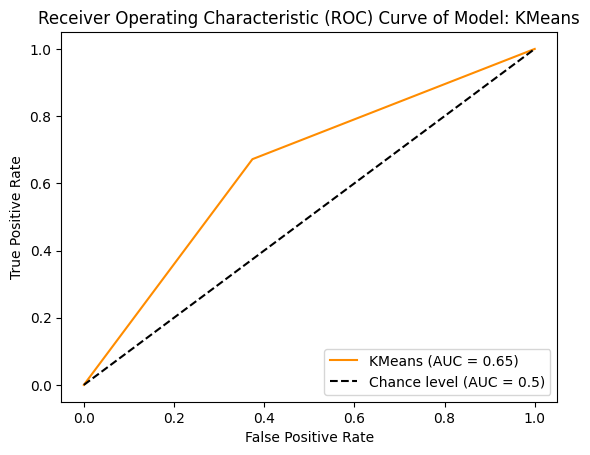

In [17]:
#K-means clustering
model_svmClassfier = train_and_evaluate("KMeans")

StratifiedKFold 1:
Training time: 4.182068347930908 s
micro f1:  0.8704676014577799
marco f1:  0.7832312430058712


StratifiedKFold 2:
Training time: 2.7851486206054688 s
micro f1:  0.8629316202359627
marco f1:  0.7718740411176134


StratifiedKFold 3:
Training time: 3.1858904361724854 s
micro f1:  0.864352338007289
marco f1:  0.769811374410676


StratifiedKFold 4:
Training time: 5.2415735721588135 s
micro f1:  0.8651553523997776
marco f1:  0.7717561666548854


StratifiedKFold 5:
Training time: 3.0940380096435547 s
micro f1:  0.8615726728025203
marco f1:  0.7724368583935686


StratifiedKFold 6:
Training time: 4.268152236938477 s
micro f1:  0.8665760701711038
marco f1:  0.7795672164084378


StratifiedKFold 7:
Training time: 3.5859742164611816 s
micro f1:  0.861881524491939
marco f1:  0.7667447393110843


StratifiedKFold 8:
Training time: 3.1082258224487305 s
micro f1:  0.8635493236148002
marco f1:  0.7689140633611946


StratifiedKFold 9:
Training time: 7.4059507846832275 s
micro f1:  0.8

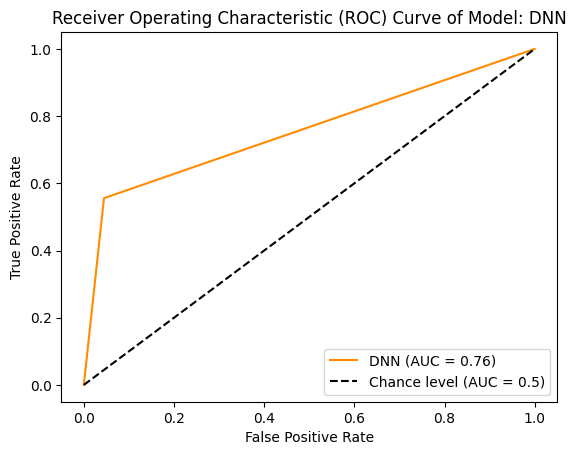

In [18]:
#Deep Neural Network
model_svmClassfier = train_and_evaluate("DNN")

StratifiedKFold 1:
Training time: 0.39805102348327637 s
micro f1:  0.8105503737105442
marco f1:  0.7154210451646292


StratifiedKFold 2:
Training time: 0.40318799018859863 s
micro f1:  0.8122181728334054
marco f1:  0.7158765197956543


StratifiedKFold 3:
Training time: 0.388871431350708 s
micro f1:  0.8103650626968929
marco f1:  0.7131975136913218


StratifiedKFold 4:
Training time: 0.39945077896118164 s
micro f1:  0.8087590339119155
marco f1:  0.7083482647234214


StratifiedKFold 5:
Training time: 0.40203142166137695 s
micro f1:  0.8080795601951941
marco f1:  0.7107146179950239


StratifiedKFold 6:
Training time: 0.39731359481811523 s
micro f1:  0.8132682685774291
marco f1:  0.7182310950045593


StratifiedKFold 7:
Training time: 0.3913884162902832 s
micro f1:  0.8095620483044041
marco f1:  0.712264536573421


StratifiedKFold 8:
Training time: 0.3944716453552246 s
micro f1:  0.8085119525603807
marco f1:  0.7085508491683468


StratifiedKFold 9:
Training time: 0.3908510208129883 s
micro 

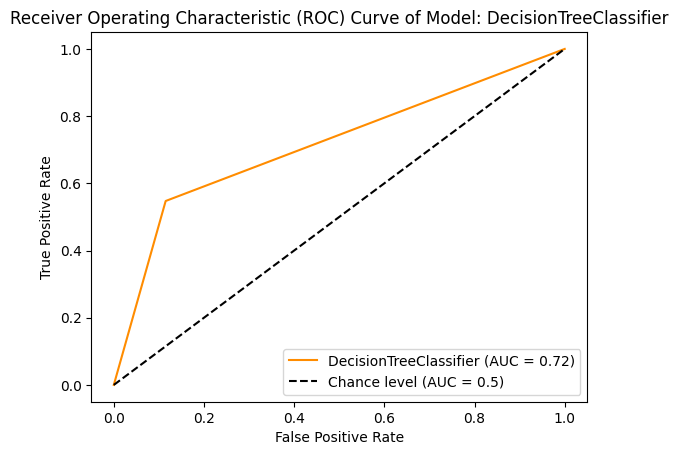

In [12]:
#Decision tree
model_DecisionTreeClassifier = train_and_evaluate("DecisionTreeClassifier")

StratifiedKFold 1:
Training time: 13.209662914276123 s
micro f1:  0.8469331027240719
marco f1:  0.7560568602311858


StratifiedKFold 2:
Training time: 13.269941329956055 s
micro f1:  0.8457594663042807
marco f1:  0.7527267889948874


StratifiedKFold 3:
Training time: 13.257141351699829 s
micro f1:  0.8424238680585583
marco f1:  0.747868952493287


StratifiedKFold 4:
Training time: 13.229126214981079 s
micro f1:  0.8468713323861882
marco f1:  0.7539107767656461


StratifiedKFold 5:
Training time: 13.480064392089844 s
micro f1:  0.8445858298844895
marco f1:  0.7523160049804938


StratifiedKFold 6:
Training time: 13.525656938552856 s
micro f1:  0.8452653036012107
marco f1:  0.7533692448698943


StratifiedKFold 7:
Training time: 13.364652633666992 s
micro f1:  0.842979801099512
marco f1:  0.7501165972499515


StratifiedKFold 8:
Training time: 13.438738346099854 s
micro f1:  0.8396442028537896
marco f1:  0.7424533352891203


StratifiedKFold 9:
Training time: 13.230824947357178 s
micro f1:  

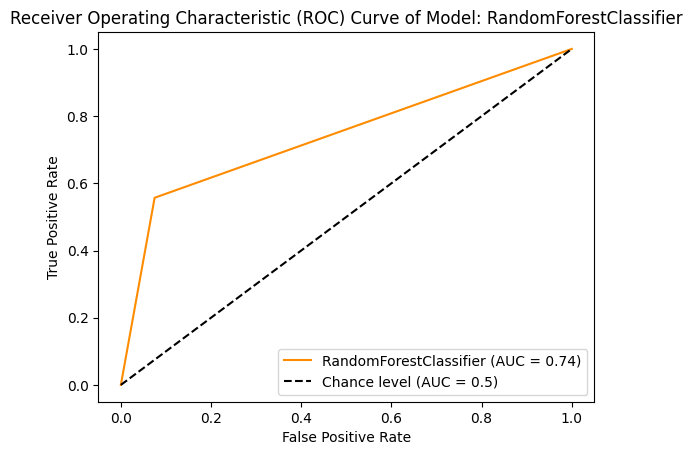

In [13]:
#Random Forest
model_RandomForestClassifier = train_and_evaluate("RandomForestClassifier")

StratifiedKFold 1:
Training time: 0.18677973747253418 s
micro f1:  0.8715794675396874
marco f1:  0.7884026616393194


StratifiedKFold 2:
Training time: 0.1475539207458496 s
micro f1:  0.8680585582803138
marco f1:  0.7826290319579546


StratifiedKFold 3:
Training time: 0.14418864250183105 s
micro f1:  0.8661436778059176
marco f1:  0.7793898447771713


StratifiedKFold 4:
Training time: 0.14407873153686523 s
micro f1:  0.8651553523997776
marco f1:  0.7771914429039828


StratifiedKFold 5:
Training time: 0.14458179473876953 s
micro f1:  0.8649082710482426
marco f1:  0.777750762458782


StratifiedKFold 6:
Training time: 0.14427804946899414 s
micro f1:  0.8683056396318488
marco f1:  0.7835328150071096


StratifiedKFold 7:
Training time: 0.1513071060180664 s
micro f1:  0.8649082710482426
marco f1:  0.7769547790196394


StratifiedKFold 8:
Training time: 0.14770984649658203 s
micro f1:  0.8631787015874977
marco f1:  0.7739833257257276


StratifiedKFold 9:
Training time: 0.14656853675842285 s
mic

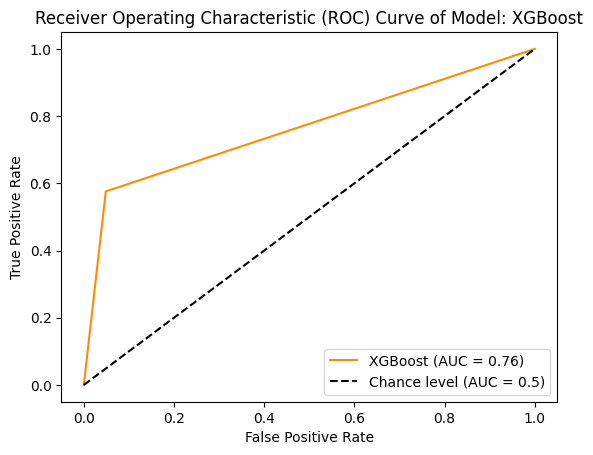

In [16]:
#XGBoost
model_XGBoost = train_and_evaluate("XGBoost")

In [ ]:
#NaiveBayes

## Submission of predicting testset label

In [67]:
#Read test data
source_path = "5. Binary Classification with a Bank Churn Dataset/test.csv"
df_test = pd.read_csv(source_path)
df_test

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110018,275052,15662091,P'eng,570,Spain,Male,29.0,7,116099.82,1,1.0,1.0,148087.62
110019,275053,15774133,Cox,575,France,Female,36.0,4,178032.53,1,1.0,1.0,42181.68
110020,275054,15728456,Ch'iu,712,France,Male,31.0,2,0.00,2,1.0,0.0,16287.38
110021,275055,15687541,Yegorova,709,France,Female,32.0,3,0.00,1,1.0,1.0,158816.58


In [72]:
#Read test data
source_path = "5. Binary Classification with a Bank Churn Dataset/test.csv"
df_test = pd.read_csv(source_path)

#Mapping gender and geography to numeric values
df_process_test = df_test 
df_process_test['Gender'].replace({'Male': 0, 'Female': 1},inplace=True)
df_process_test['Geography'].replace({'France': 0, 'Germany': 1,'Spain':2},inplace=True)

#standardlization
df_z_test = z_scaler.transform(df_process_test.drop(columns=['id','CustomerId','Surname']))
#normalization
df_norm_test = minmax_scaler.transform(df_z_test)

#Convert to dataframe
df_processed_test = pd.DataFrame(df_norm_test)
df_processed_test.columns = column_labels
df_processed_test.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,0.398633,0.0,1.0,0.096154,0.2,0.000000,0.5,0.0,1.0,0.804903
1,0.619590,0.0,1.0,0.538462,0.2,0.000000,0.0,1.0,0.0,0.362723
2,0.558087,0.0,1.0,0.307692,0.7,0.000000,0.5,1.0,0.0,0.694419
3,0.615034,0.0,0.0,0.346154,0.8,0.000000,0.0,1.0,0.0,0.569654
4,0.776765,0.5,0.0,0.384615,1.0,0.508683,0.0,1.0,0.0,0.697164


In [ ]:
#Predict labels
#y_pred_test = modelname.predict(df_processed_test)


In [ ]:
#Output the result with CustomerID and Exited columns in csv format.
#result_df = pd.DataFrame({'CustomerId': df_test['CustomerId'], 'Exited': y_pred_test})
#result_df.to_csv('5. Binary Classification with a Bank Churn Dataset/submissions.csv', index=False)